In [19]:
# подключаем пакеты
import pandas as pd
import datetime as dt

from io import StringIO
import requests

import plotly
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import plotly.io as pio
pio.templates.default = "none"

# для работы plotly в jypyter могут потребоваться дополнения:
# https://github.com/plotly/plotly.py

In [9]:
# так как pd.read_csv не всегда хорошо читает ссылку, оборачиваем в функцию с использованием костылей
def read_url_data(url):
    tmp = requests.get(url).text  
    return pd.read_csv(StringIO(tmp))

In [10]:
#  импортируем данные
users = read_url_data('https://gitlab.com/upravitelev/mar191f/raw/master/data/users.csv')
auth = read_url_data('https://gitlab.com/upravitelev/mar191f/raw/master/data/auth.csv')

In [12]:
# конвертируем строковые значения дат в формат даты
users['install_date'] = pd.to_datetime(users['install_date'])
auth['login_date'] = pd.to_datetime(auth['login_date'])

In [13]:
# дополняем таблицу логинов данными по дате инсталла
auth = pd.merge(auth, users, how='left', on='user_id')

# вычисляем lifetime
auth['lifetime'] = (auth['login_date'] - auth['install_date']).dt.days
auth[:3]

user_id login_date install_date       channel  lifetime
0  0000bcbe 2020-06-11   2020-06-11  Facebook Ads         0
1  0000bcbe 2020-06-11   2020-06-11  Facebook Ads         0
2  0000bcbe 2020-06-11   2020-06-11  Facebook Ads         0

In [16]:
# группируем пользователей по возрасту жизни в приложении
auth.loc[auth['lifetime'] == 0, 'group'] = '0 days'
auth.loc[(auth['lifetime'] >= 1) & (auth['lifetime'] <= 7), 'group'] = '1-7 days'
auth.loc[(auth['lifetime'] >= 8) & (auth['lifetime'] <= 28), 'group'] = '8-28 days'
auth.loc[auth['lifetime'] >= 29, 'group'] = '29+ days'

# считаем DAU по структуре аудитории
dau_structure = auth.groupby(['login_date', 'group'])['user_id'].nunique().reset_index()
dau_structure.rename(columns={'user_id':'n_users'}, inplace=True)

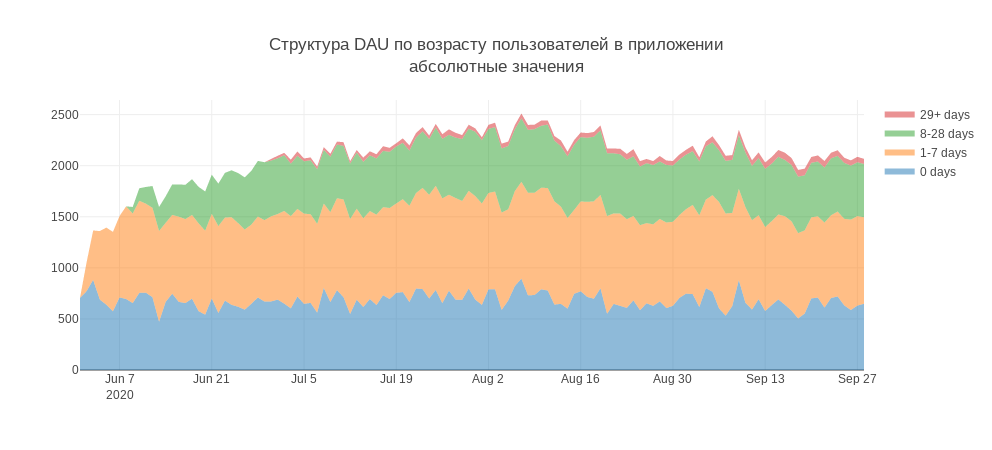

In [20]:
fig_str = go.Figure()
for i in ['0 days', '1-7 days', '8-28 days', '29+ days']:
    tmp = dau_structure[dau_structure['group'] == i]
    trace = go.Scatter(
        x=tmp['login_date'],
        y=tmp['n_users'],
        name=i,
        mode='none',
        stackgroup='one'        
    )
    fig_str.add_trace(trace)
    
fig_str.layout.update(
    title='Структура DAU по возрасту пользователей в приложении<br>абсолютные значения'
)

fig_str.show()

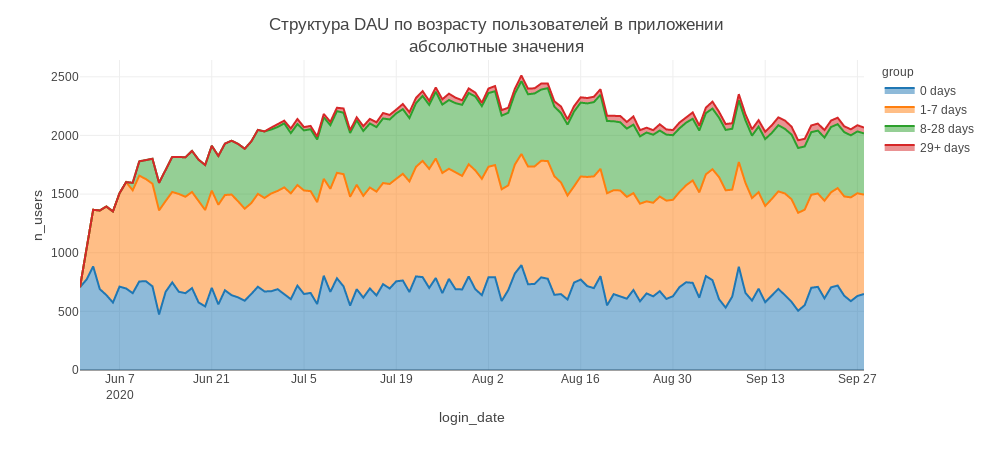

In [29]:
# вариант 2, с помощью модуля plotly.express
import plotly.express as px
fig = px.area(dau_structure, x="login_date", y="n_users", color="group")
fig.layout.update(
    title='Структура DAU по возрасту пользователей в приложении<br>абсолютные значения'
)
fig.show()

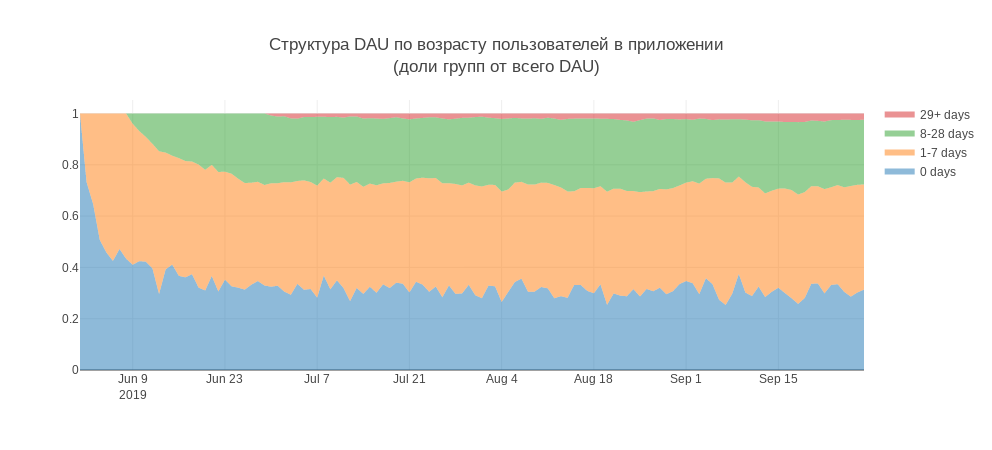

In [36]:
# считаем, сколько суммарно было пользователей всех групп в день
dau_structure = pd.merge(
    dau_structure,    
    dau_structure.groupby('login_date')['n_users'].sum().reset_index().rename(columns={'n_users':'total_users'}),
    how='left',
    on='login_date'
)

# доля каждой группы от дневного DAU
dau_structure['share'] = dau_structure['n_users'] / dau_structure['total_users']

# рисуем area plot по структуре DAU в долях
fig_str2 = go.Figure()
for i in dau_structure['group'].unique():
    tmp = dau_structure[dau_structure['group'] == i]
    trace = go.Scatter(
        x=tmp['login_date'],
        y=tmp['share'],
        name=i,
        mode='none',
        stackgroup='one'        
    )
    fig_str2.add_trace(trace)
    
fig_str2.layout.update(
    title='Структура DAU по возрасту пользователей в приложении<br>(доли групп от всего DAU)'
)

iplot(fig_str2, show_link=False)

In [13]:
auth[:3]

user_id login_date install_date       channel  lifetime
0  e0f1bd5c 2019-06-01   2019-06-01  Facebook Ads         0
1  135c6da2 2019-06-01   2019-06-01  Facebook Ads         0
2  efb9ec51 2019-06-01   2019-06-01  Facebook Ads         0

0.00   -117.0
0.25      0.0
0.50      1.0
0.75      4.0
1.00    116.0
Name: lifetime, dtype: float64

In [17]:
np.quantile(auth[['lifetime']], q=)

TypeError: quantile() missing 1 required positional argument: 'q'

In [16]:
help(np.quantile)

Help on function quantile in module numpy:

quantile(a, q, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)
    Compute the q-th quantile of the data along the specified axis.
    ..versionadded:: 1.15.0
    
    Parameters
    ----------
    a : array_like
        Input array or object that can be converted to an array.
    q : array_like of float
        Quantile or sequence of quantiles to compute, which must be between
        0 and 1 inclusive.
    axis : {int, tuple of int, None}, optional
        Axis or axes along which the quantiles are computed. The
        default is to compute the quantile(s) along a flattened
        version of the array.
    out : ndarray, optional
        Alternative output array in which to place the result. It must
        have the same shape and buffer length as the expected output,
        but the type (of the output) will be cast if necessary.
    overwrite_input : bool, optional
        If True, then allow the inp